## Notebook analysing TÜV-Nord data coming with the patent for mobile crash detection
In particular Test-files 1 and 2 and TestCA. Header descriptions are contained in _data/data.txt_. Log rate is $10Hz$ and offset for all values is zero. Before this particular analysis, I used the VBOX-Analyser from [perfdb.com](http://www.perfdb.com/) which detects possible test-cases and plots available data. Having put every dataset into that tool it seems that there have only been taken ac- and deceleration tests into account. This notebook shall provide proof for that or find more information in the provided dataset in csv-format.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
matplotlib.style.use('seaborn-notebook')
plt.rcParams['figure.figsize'] = (14.0, 11.0)

Import Testfiles and drop columns containing no information. In case of _data/Test1.csv_ we can drop **yaw-calc, slip, YAW__, YAW_**.

In [2]:
data1 = pd.read_csv('data/Test1.csv')
data2 = pd.read_csv('data/Test2.csv')
dataCA = pd.read_csv('data/TestCA.csv')

Clean tables from previously enumerated columns. These store no information due to either zero variance or invalid file readings caused by a corrupt csv file.

In [3]:
def convert_and_clean(frame):
    for head in frame:
        if 'object:dense' in frame[head].ftypes:
            frame[head] = frame[head].apply(lambda x: x.replace(',', '.').replace('+', ''))
            frame[head] = frame[head].astype(float)
        var = 1.0
        try:
            var = frame[head].var()
        except:
            continue
        if 'Unnamed' in head or var == 0:
            frame = frame.drop(head, axis=1)
    return frame

In [4]:
data1 = convert_and_clean(data1)
data2 = convert_and_clean(data2)
dataCA = convert_and_clean(dataCA)

Derivate any speed value by default given in $\frac{km}{h}$ in order to get the acceleration values in $\frac{m}{s^2}$. Thus the maximum momentum can be obtained at any given point indicating either acceleration or deceleration.

In [5]:
def derivate_speed(frame, spd='velocity', t='time', c='acc', v_val='kmh'):
    div = 1000/3600 if v_val == 'kmh' else 1
    init_spd, init_t = 0.0, frame[t].min()
    accs = []
    for i in range(len(frame)):
        dv = (frame[spd][i] - init_spd) * div
        dt = (frame[t][i] - init_t)
        if dt > 60:
            print('Differential break at', i)
        accs.append(.0 if dt == 0.0 else dv / dt)
        init_spd = frame[spd][i]
        init_t = frame[t][i]
    frame[c] = accs
    return frame

In [6]:
def add_acc_cols(frame):
    if 'velocity' in frame:
        frame = derivate_speed(frame)
    if 'vert-vel' in frame:
        frame = derivate_speed(frame, spd='vert-vel', c='vert-acc', v_val='ms')
    return frame

In [7]:
data1 = add_acc_cols(data1)
data2 = add_acc_cols(data2)
dataCA = add_acc_cols(dataCA)

In [13]:
def plot_data(frame):
    plt.figure()
    frame['velocity'].plot(linewidth=0.7, label='Velocity km/h')
    frame['acc'].plot(linewidth=0.7, label='Acceleration m/ss')
    plt.legend()
    plt.xlabel('Tenth seconds')
    plt.figure()
    frame['vert-vel'].plot(linewidth=0.7, label='Vertical velocity m/s')
    frame['vert-acc'].plot(linewidth=0.7, label='Vertical acceleration m/ss')
    plt.xlabel('Tenth seconds')
    plt.legend()

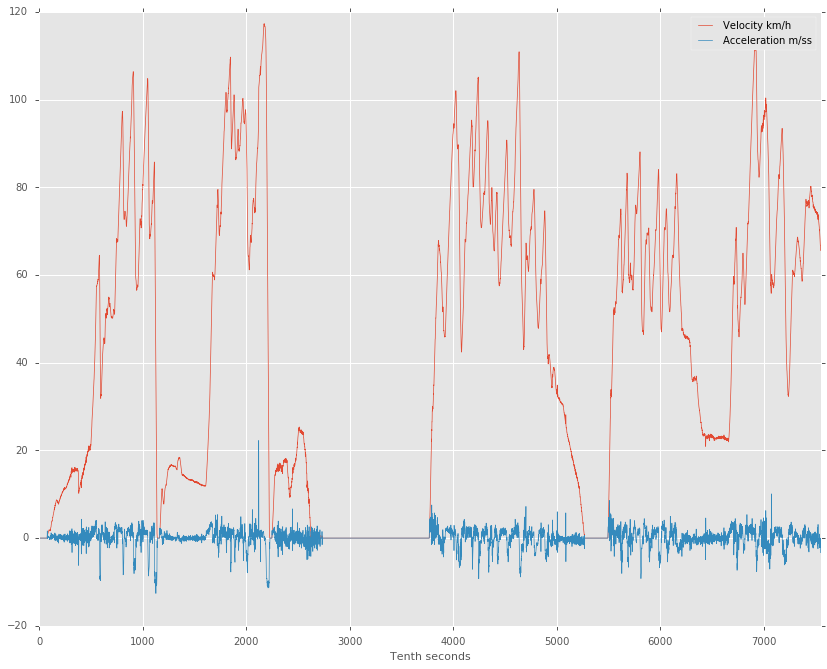

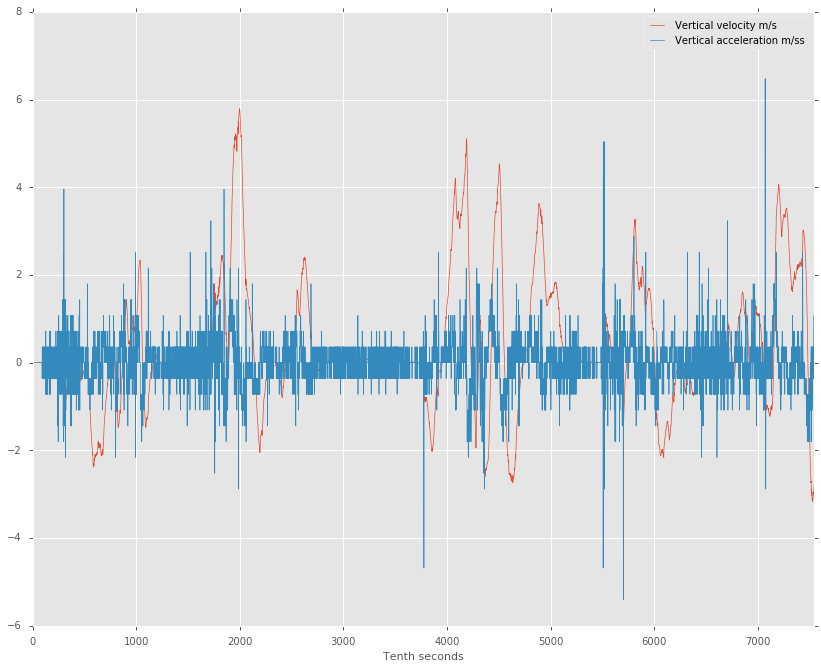

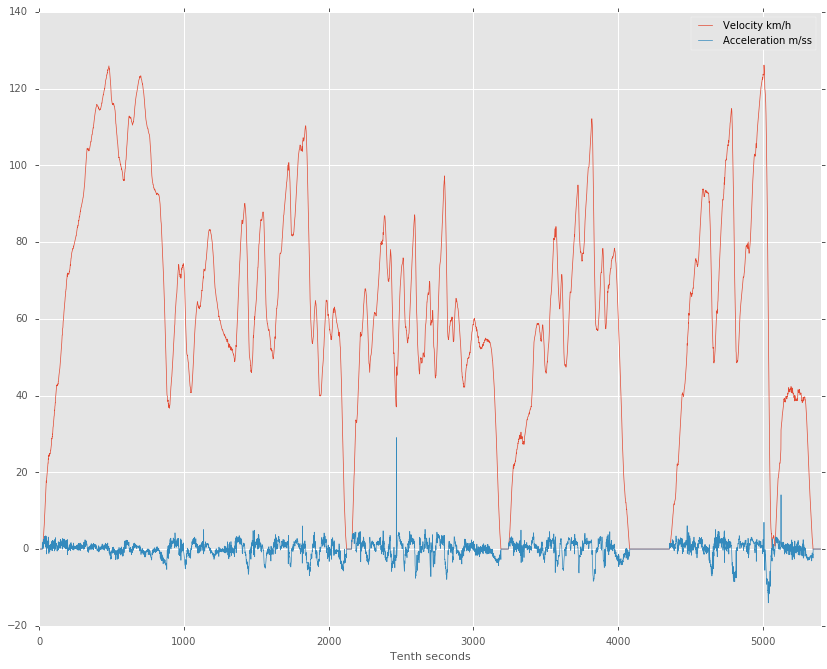

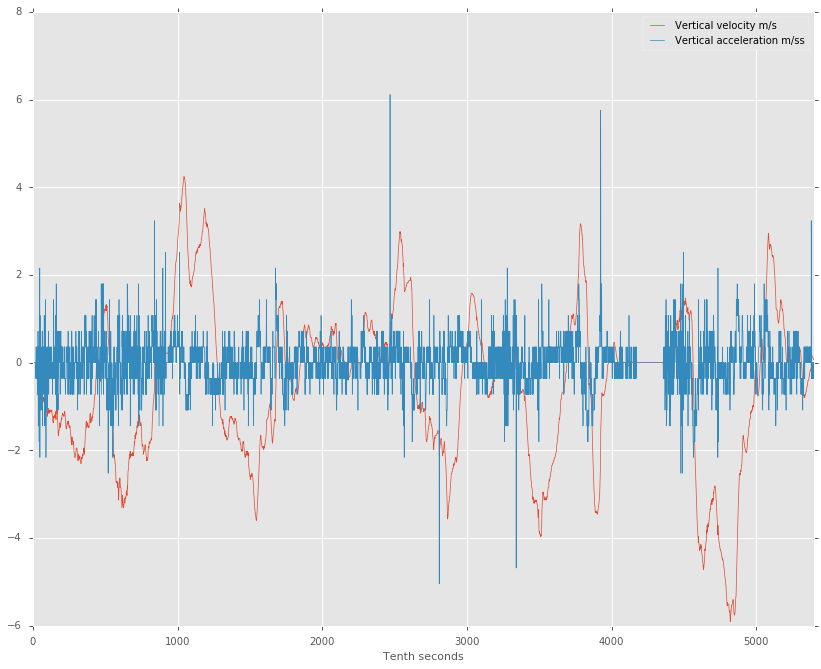

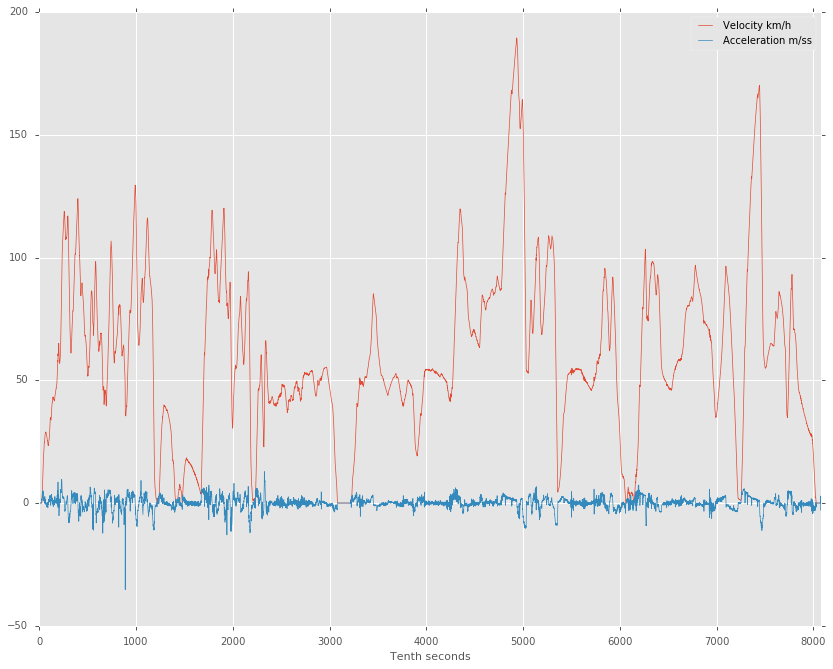

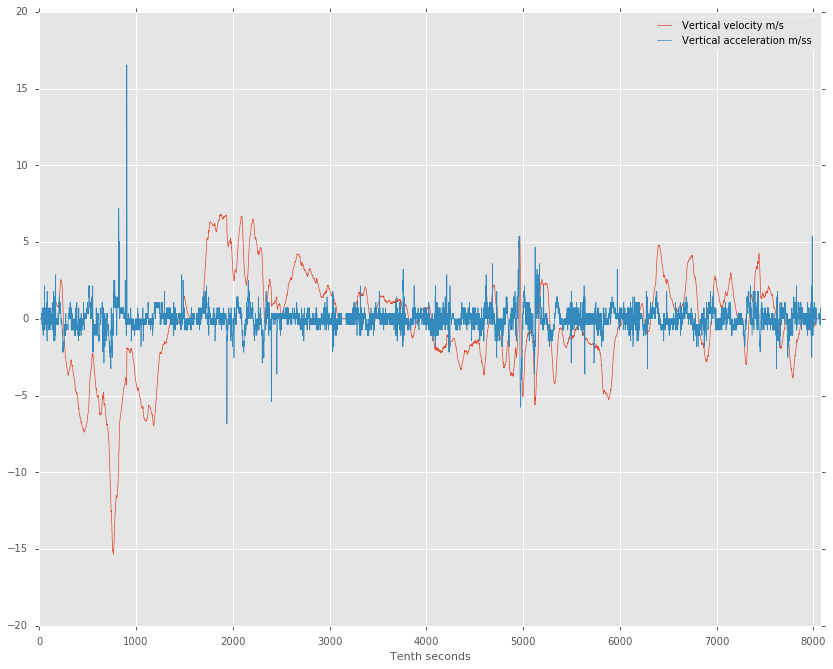

In [16]:
start, end = 0, 10000
plot_data(data1[start:end])
plot_data(data2[start:end])
plot_data(dataCA[start:end])

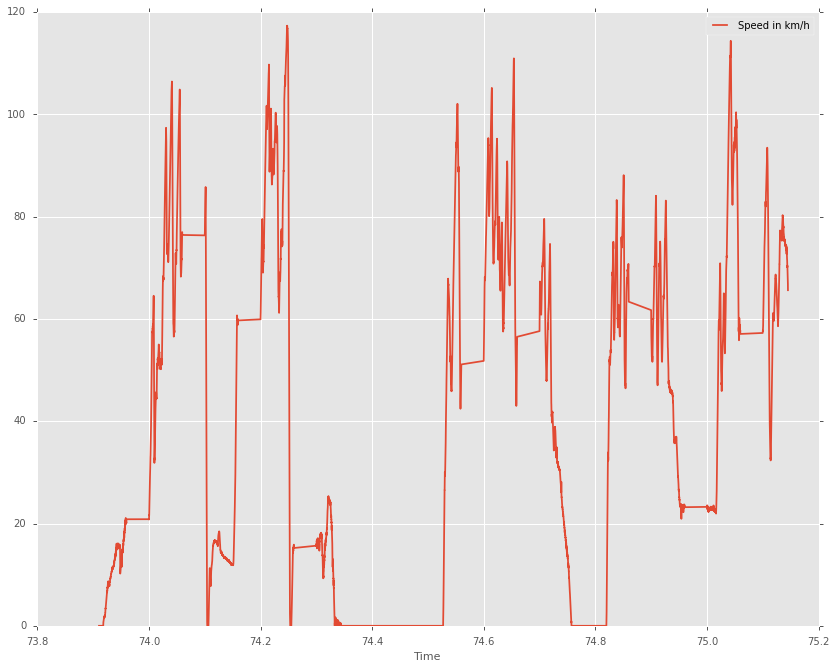

In [18]:
plt.plot(data1['time'].apply(lambda x: (x/1000)), data1['velocity'], label='Speed in km/h')
plt.xlabel('Time')
plt.legend()
plt.show()

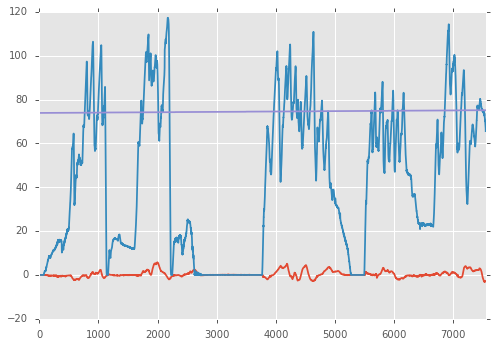

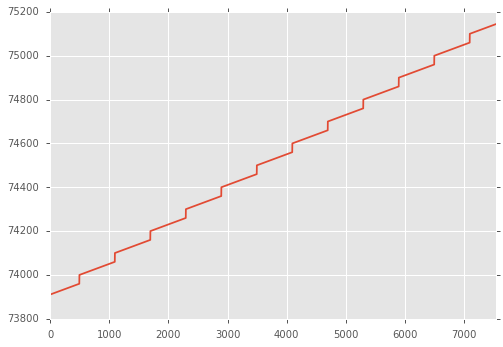

In [11]:
data1 = data1.sort_values(by=['time'])
data2 = data2.sort_values(by=['time'])
#data1['time'].plot()
data1['vert-vel'].plot()
data1['velocity'].plot()
#data1['sats'].plot()
start_time = data1['time'].min()
data1['time'].apply(lambda x: (x / 1000)).plot()
matplotlib.pyplot.show()
data1['time'].plot()